<a href="https://colab.research.google.com/github/baont/-baont.github.io/blob/master/feq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import pandas as pd
import math
import numpy as np
from scipy.stats import lognorm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.layers import Dense, SimpleRNN
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
# from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from pyarrow import feather
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
notebook_path = os.getcwd()
notebook_path

'/content'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ETH_USDT_USDT-1m-futures.feather to ETH_USDT_USDT-1m-futures.feather


In [5]:
df = pd.read_feather('/content/ETH_USDT_USDT-1m-futures.feather')

In [6]:
df['close'] = df['close'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['volume'] = df['volume'].astype(float)


In [7]:
df['dif'] = (df['close'] - df['close'].shift(1))*100 / df['close'].shift(1)

In [8]:
observe_duration = 10
time_steps = 90
# in percent
profit_margin = 5
leverage = 60
diff_limit = 0.2

closes = df['close'].values[1:]
opens = df['open'].values[1:]
highs = df['high'].values[1:]
lows = df['low'].values[1:]

diffs = df['dif'].values[1:]
for i in range(len(diffs)):
    if diffs[i] > diff_limit:
        diffs[i] = diff_limit
    if diffs[i] < -diff_limit:
        diffs[i] = -diff_limit
diffs = [[d] for d in diffs]

x_len = len(diffs) - (time_steps + observe_duration) + 1

In [9]:
data = diffs
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [ ]:
import pickle

with open("scaler.pickle", "wb") as outfile:
 pickle.dump(scaler, outfile)

In [10]:
labels = []

x = []

for i in range(len(data) - time_steps - observe_duration):
    xx = data[i: i + time_steps]
    x.append(xx)
    label = 0
    price_in = opens[i + time_steps]
    for j in range(i + time_steps, i + time_steps + observe_duration):
        min_inc = 10
        max_inc = -10
        inc = ((closes[j] - price_in) * 100 * leverage) / price_in
        if inc > max_inc:
            max_inc = inc
        if inc < min_inc:
            min_inc = inc

        if max_inc > profit_margin + 1 and min_inc > -profit_margin + 1:
            label = 1
            break
        if min_inc < -profit_margin - 1 and max_inc < profit_margin - 1:
            label = -1
            break

    labels.append(label)


In [27]:
labels[10:20]


[0, 0, 0, 0, 0, -1, 0, -1, 0, 1]

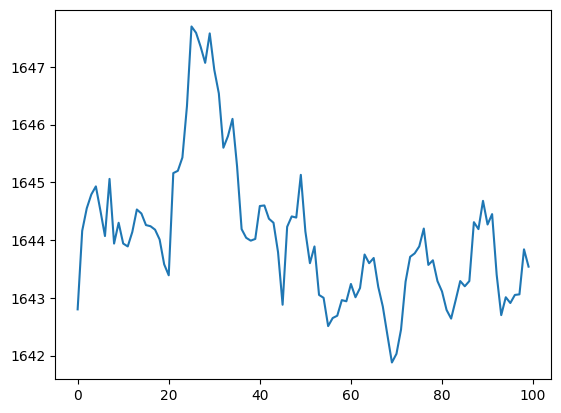

In [28]:
i = 15
plt.plot(closes[i: i + time_steps + observe_duration])

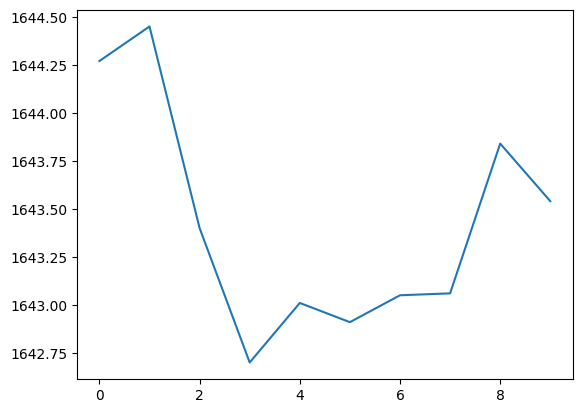

In [29]:
plt.plot(closes[i + time_steps: i + time_steps + observe_duration])

In [11]:
count1 = 0
count2 = 0
count3 = 0

for i in range(len(labels)):
    if labels[i] == 0:
        count1 = count1 + 1
    if labels[i] == 1:
        count2 = count2 + 1
    if labels[i] == -1:
        count3 = count3 + 1

In [12]:
count1

24333

In [13]:
count2

9477

In [14]:
count3

9361

In [ ]:
labels[:10]

In [30]:
encoded_Y = np.array([a + (0 - min(labels)) for a in labels])
y = to_categorical(encoded_Y)

In [32]:
# shufle data

X, y = shuffle(x, y, random_state=0)
X = np.array(X)
y = np.array(y)

In [33]:
r = 0.85
n = int(r*len(X))
X_train = X[:n]
y_train = y[:n]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

In [34]:
from keras.callbacks import EarlyStopping

model = Sequential()
# model.add(SimpleRNN(300, input_shape=(time_steps,1), activation='tanh'))
# model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(100, input_dim=4, activation='relu'))
# model.add(Dense(3, activation='softmax'))

# model.add(LSTM(500, input_shape=(time_steps, 1), dropout=0.2, recurrent_dropout=0.2))
model.add(GRU(500, input_shape=(time_steps, 1), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(GRU(250, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(250, input_dim=4, activation='relu'))
model.add(Dense(125, input_dim=4, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.build((None,time_steps,1))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 90, 500)           754500    
                                                                 
 gru_1 (GRU)                 (None, 250)               564000    
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dense_1 (Dense)             (None, 125)               31375     
                                                                 
 dense_2 (Dense)             (None, 3)                 378       
                                                                 
Total params: 1413003 (5.39 MB)
Trainable params: 1413003 (5.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
X = X[-14400:]
y = y[-14400:]

In [36]:
history = model.fit(X, y, epochs=80, batch_size=10,validation_split=0.1)


Epoch 1/80
1296/1296 [==============================] - 317s 237ms/step - loss: 0.8897 - accuracy: 0.6025 - val_loss: 0.8682 - val_accuracy: 0.6028
Epoch 2/80
1296/1296 [==============================] - 309s 238ms/step - loss: 0.8625 - accuracy: 0.6149 - val_loss: 0.8652 - val_accuracy: 0.6028
Epoch 3/80
1296/1296 [==============================] - 307s 237ms/step - loss: 0.8552 - accuracy: 0.6181 - val_loss: 0.8725 - val_accuracy: 0.6146
Epoch 4/80
1296/1296 [==============================] - 306s 236ms/step - loss: 0.8523 - accuracy: 0.6171 - val_loss: 0.8979 - val_accuracy: 0.5979
Epoch 5/80
1296/1296 [==============================] - 305s 235ms/step - loss: 0.8531 - accuracy: 0.6167 - val_loss: 0.8815 - val_accuracy: 0.6049
Epoch 6/80
1296/1296 [==============================] - 305s 235ms/step - loss: 0.8514 - accuracy: 0.6164 - val_loss: 0.8617 - val_accuracy: 0.6160
Epoch 7/80
1296/1296 [==============================] - 304s 235ms/step - loss: 0.8524 - accuracy: 0.6216 - val_

In [ ]:
import os
import tensorflow as tf
notebook_path = os.getcwd()
model_path = f"{notebook_path}/model/rnn"

In [ ]:
version = 3
export_path = os.path.join(model_path, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}